In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
import seaborn as sns
import subprocess
from pybedtools import BedTool


In [2]:
#use only 100 random genes
random_100 = '../../data/genes/random_100.csv'
constitutive_variable = '../../data/genomes/ara_housekeeping_list.out'

In [3]:
random_genes = pd.read_csv(random_100, header=0)
promoters = pd.read_table(constitutive_variable, sep='\t', header=None)
cols2 = ['promoter_AGI', 'gene_type']
promoters.columns = cols2

In [4]:
random_genes = random_genes[['promoter_AGI','gene_type']]

In [5]:
promoters_filtered = promoters.copy()
#drop randCont rows
promoters_filtered = promoters_filtered[~(promoters.gene_type == 'randCont')]
promoters_filtered

,promoter_AGI,gene_type
0,AT4G34270,housekeeping
1,AT3G32260,housekeeping
2,AT1G59830,housekeeping
3,AT4G33380,housekeeping
4,AT2G28390,housekeeping
...,...,...
195,AT3G44070,highVar
196,AT5G61360,highVar
197,AT5G16100,highVar
198,AT3G60570,highVar


In [6]:
#concat the dfs, and drop rows if present in groupby_promoter

promoters_filtered = pd.concat([promoters_filtered, random_genes], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True, sort=False)
promoters_filtered
#write to file for future
promoters_filtered.to_csv('../../data/genes/constitutive-variable-random_100_each.csv')

In [7]:
TATA_presence = '../../data/EPD_promoter_analysis/responsive_housekeeping_TATA_box_positive.bed'
TFs = '../../data/genes/housekeeping_variable_TFs_only.txt'
GC_box_file = '../../data/EPD_promoter_analysis/responsive_housekeeping_GCbox_positive.bed'
Inr_file = '../../data/EPD_promoter_analysis/responsive_housekeeping_Inr_positive.bed'
CCAAT_box_file = '../../data/EPD_promoter_analysis/responsive_housekeeping_CCAAT_box_positive.bed'

In [8]:
TATA = pd.read_table(TATA_presence, sep='\t', header=None, skiprows=2)
TF_promoters = pd.read_csv(TFs, header=0)
GC_box = pd.read_table(GC_box_file, sep='\t', header=None, skiprows=2)
Inr = pd.read_table(Inr_file, sep='\t', header=None, skiprows=2)
CCAAT_box = pd.read_table(CCAAT_box_file, sep='\t', header=None, skiprows=2)

In [9]:
#remove duplicates from TF_Promoters
TF_promoters = TF_promoters.drop_duplicates(subset='Gene_ID')

In [10]:
#columns
cols = ['chr', 'start', 'stop', 'gene_ID', 'number', 'strand']
TATA.columns = cols
GC_box.columns = cols
Inr.columns = cols
CCAAT_box.columns = cols
TATA['TATA_present'] = 'yes'
GC_box['GC_box_present'] = 'yes'
Inr['Inr_present']  = 'yes'
CCAAT_box['CCAAT_box_present'] = 'yes'

TF_promoters.rename(columns = {'Gene_ID':'promoter_AGI'}, inplace = True)
TF_promoters['is_TF'] = 'yes'

In [11]:
#remove last 2 characters of promoter_AGI in TATA dataframe
TATA['promoter_AGI'] = TATA.gene_ID.str.slice(0, -2)
GC_box['promoter_AGI'] = GC_box.gene_ID.str.slice(0, -2)
Inr['promoter_AGI'] = Inr.gene_ID.str.slice(0, -2)
CCAAT_box['promoter_AGI'] = CCAAT_box.gene_ID.str.slice(0, -2)

In [12]:
merged = pd.merge(promoters_filtered,TATA[['promoter_AGI', 'TATA_present']], how='left', on='promoter_AGI')

In [13]:
merged = pd.merge(merged,GC_box[['promoter_AGI', 'GC_box_present']], how='left', on='promoter_AGI')

In [14]:
merged = pd.merge(merged,Inr[['promoter_AGI', 'Inr_present']], how='left', on='promoter_AGI')

In [15]:
merged = pd.merge(merged,CCAAT_box[['promoter_AGI', 'CCAAT_box_present']], how='left', on='promoter_AGI')

In [16]:
merged = pd.merge(merged, TF_promoters, how='left', on='promoter_AGI')

In [17]:
merged

,promoter_AGI,gene_type,TATA_present,GC_box_present,Inr_present,CCAAT_box_present,TF_ID,Family,is_TF
0,AT4G34270,housekeeping,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT3G32260,housekeeping,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AT1G59830,housekeeping,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AT4G33380,housekeeping,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AT2G28390,housekeeping,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
295,AT5G13410,randCont,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,AT5G56090,randCont,yes,NaN,NaN,NaN,NaN,NaN,NaN
297,AT5G05170,randCont,NaN,NaN,NaN,yes,NaN,NaN,NaN
298,AT3G18110,randCont,NaN,NaN,yes,NaN,NaN,NaN,NaN


In [18]:
#Fill NaN with 'No'
merged_nos = merged[2:].fillna('no')

In [19]:
## how many TATA
merged_TATA = merged_nos.groupby('gene_type')['TATA_present'].value_counts()
merged_TATA

gene_type     TATA_present
highVar       no              74
              yes             26
housekeeping  no              87
              yes             11
randCont      no              75
              yes             25
Name: TATA_present, dtype: int64

In [20]:
## how many Inr
merged_Inr = merged_nos.groupby('gene_type')['Inr_present'].value_counts()
merged_Inr

gene_type     Inr_present
highVar       no             75
              yes            25
housekeeping  no             69
              yes            29
randCont      no             63
              yes            37
Name: Inr_present, dtype: int64

In [21]:
## how many GC_box
merged_GC_box = merged_nos.groupby('gene_type')['GC_box_present'].value_counts()
merged_GC_box

gene_type     GC_box_present
highVar       no                96
              yes                4
housekeeping  no                92
              yes                6
randCont      no                99
              yes                1
Name: GC_box_present, dtype: int64

In [22]:
## how many CCAAT_box
merged_CCAAT_box = merged_nos.groupby('gene_type')['CCAAT_box_present'].value_counts()
merged_CCAAT_box

gene_type     CCAAT_box_present
highVar       no                   82
              yes                  18
housekeeping  no                   78
              yes                  20
randCont      no                   84
              yes                  16
Name: CCAAT_box_present, dtype: int64

In [23]:
## how many TFs
merged_TF = merged_nos.groupby('gene_type')['is_TF'].value_counts()
merged_TF

gene_type     is_TF
highVar       no       95
              yes       5
housekeeping  no       97
              yes       1
randCont      no       95
              yes       5
Name: is_TF, dtype: int64

In [24]:
# make separate dfs based on gene type

In [25]:
#get names of each promoter type
pd.Categorical(merged_nos.gene_type)
names = merged.gene_type.unique()
for name in names:
    print(name)

housekeeping
highVar
randCont


In [26]:
#Chi squared: H0:There is no statistically significant relationship between gene type and the presence of the feature.

#Ha:There is a statistically significant relationship between gene type and the presence of the feature.

In [27]:
#first remove randCont
merged_norandom = merged_nos[(merged_nos.gene_type == 'housekeeping') | (merged_nos.gene_type == 'highVar')]
merged_norandom

,promoter_AGI,gene_type,TATA_present,GC_box_present,Inr_present,CCAAT_box_present,TF_ID,Family,is_TF
2,AT1G59830,housekeeping,no,no,no,no,no,no,no
3,AT4G33380,housekeeping,no,no,no,no,no,no,no
4,AT2G28390,housekeeping,no,no,no,no,no,no,no
5,AT5G55840,housekeeping,no,no,yes,no,no,no,no
6,AT1G13320,housekeeping,no,no,yes,no,no,no,no
...,...,...,...,...,...,...,...,...,...
195,AT3G44070,highVar,no,no,no,no,no,no,no
196,AT5G61360,highVar,no,yes,no,no,no,no,no
197,AT5G16100,highVar,no,no,no,no,no,no,no
198,AT3G60570,highVar,yes,no,no,no,no,no,no


In [28]:

# Constructing the Contingency Table

# The next step is to format the data into a frequency count table. This is called a Contingency Table, we can accomplish this by using the pd.crosstab() function in pandas.
contingency_table = pd.crosstab(
    merged_norandom['gene_type'],
    merged_norandom['TATA_present'],
    margins = True
)
contingency_table

TATA_present,no,yes,All
gene_type,,,
highVar,74,26,100
housekeeping,87,11,98
All,161,37,198


In [29]:
# First, let's put the observed values into a one dimensional array, reading the contingency table from left to right then top to bottom.
f_obs = np.append(contingency_table.iloc[0][0:2].values, contingency_table.iloc[1][0:2].values)
f_obs

array([74, 26, 87, 11])

In [30]:
#Next, we need to calculate the expected values. The expected values assume that null hypothesis is true. We would need to calculate values if there is an equal percentage of males and females for each category.

In [31]:
row_sums = contingency_table.iloc[0:2,2].values
row_sums

array([100,  98])

In [32]:
col_sums = contingency_table.iloc[2,0:2].values
col_sums

array([161,  37])

In [33]:
total = contingency_table.loc['All', 'All']

f_expected = []
for j in range(2):
    for i in col_sums:
        f_expected.append(i*row_sums[j]/total)
f_expected

[81.31313131313131, 18.68686868686869, 79.68686868686869, 18.31313131313131]

In [34]:
# Now that we have all our observed and expected values, we can just plug everything into the Chi-squared test formula.

In [35]:
chi_squared_statistic = ((f_obs - f_expected)**2/f_expected).sum()
print('Chi-squared Statistic: {}'.format(chi_squared_statistic))

Chi-squared Statistic: 7.111294070087322


In [36]:
#Degrees of Freedom

# Similar to the Welch's t-test, we would have to calculate the degrees of freedom before we can determine the p-value.

#DoF=(Number of rows−1)∗(Number of columns−1)

In [37]:
dof = (len(row_sums)-1)*(len(col_sums)-1)
print("Degrees of Freedom: {}".format(dof))

Degrees of Freedom: 1


In [38]:
#make function for doing chisqaure on contingency table
def chi_stat(data, column, apply_correction):
    """function to calculate chi squared values from a dataset. You provide the column of interest containing your categories. Choose whether Yates' correction is true or false"""
    contingency_table = pd.crosstab(
    data['gene_type'],
    data[column],
    margins = True
    )
    
    f_obs = np.array([contingency_table.iloc[0][0:2].values,
                  contingency_table.iloc[1][0:2].values])
    
    statistics = stats.chi2_contingency(f_obs, correction=apply_correction)[0:3]
    return statistics

In [39]:
#With no correction, identical to manual chi sqare above
chi_stat(merged_norandom, 'TATA_present', False)

(7.111294070087322, 0.007659979301743937, 1)

In [40]:
#with Yate's correction
chi_stat(merged_norandom, 'TATA_present', True)

(6.172134960413571, 0.012977790143479771, 1)

In [41]:
#chi_stat(merged_norandom, 'TF_ID', True)

In [42]:
#Get column names of interest
cols = list(merged_norandom.columns.values)
cols_of_interest = cols[2:6] #.append('is_TF')
cols_of_interest.append('is_TF')
cols_of_interest

['TATA_present', 'GC_box_present', 'Inr_present', 'CCAAT_box_present', 'is_TF']

In [43]:
for col in cols_of_interest:
    print(col)

TATA_present
GC_box_present
Inr_present
CCAAT_box_present
is_TF


In [44]:
#calculate chi-squared, p-value and degrees of freedom with Yates' correction for all four column
#if p-value < 0.05, reject null hypothesis
for col in cols_of_interest:
    if chi_stat(merged_norandom, col, True)[1] > 0.05:
        print(f'{col}: {chi_stat(merged_norandom, col, True)}, NOT SIGNIFICANT')
    elif chi_stat(merged_norandom, col, True)[1] < 0.05:
        print(f'{col}: {chi_stat(merged_norandom, col, True)}, SIGNIFICANT')    
        

TATA_present: (6.172134960413571, 0.012977790143479771, 1), SIGNIFICANT
GC_box_present: (0.12768334780720786, 0.7208462203022798, 1), NOT SIGNIFICANT
Inr_present: (0.3201084183673465, 0.5715424967758679, 1), NOT SIGNIFICANT
CCAAT_box_present: (0.06237013292158963, 0.802788321444629, 1), NOT SIGNIFICANT
is_TF: (1.4851578443877549, 0.22296927011176992, 1), NOT SIGNIFICANT


Housekeeping genes have significantly fewer TATA boxes than variable genes 

## <b> now I need to rerun analyses using gat enrichment

If binding sites you're mapping are small, need to get the mapability genome containing all regions that are uniquely mappable with reads of 24 bases. https://genome.ucsc.edu/cgi-bin/hgTrackUi?db=hg38&g=mappability
See https://gat.readthedocs.io/en/latest/tutorialGenomicAnnotation.html

Downloaded TATA_boxes.bed and TATA_boxes.fps (both the same, different formats) from EPD
Used the following search parameters for download:
## FindM Genome Assembly : A. thaliana (Feb 2011 TAIR10/araTha1)
##Series : EPDnew, the Arabidopsis Curated Promoter Database
##Sample : TSS from EPDnew rel 004
##Repeat masking: off
##5' border: -50     3' border: 0
##Search mode: forward
##Selection mode : all matches 

In the end I didn't need these files, can use existing tatabox files for the specific genes of interest (responsive_housekeeping_TATA_box_positive.bed)

Copied the chromsizes.chr to data/EPD_promoter_analysis/TATA and converted it into a BED file for the workspace.

In [45]:
#create a bed file containing all 100 constitutive/responsive promoters with the fourth column annotating whether it's constitutive or responsive

promoters_no_random = promoters.copy()
#drop randCont rows
promoters_no_random = promoters_filtered[~(promoters.gene_type == 'randCont')]
promoters_no_random

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,promoter_AGI,gene_type
0,AT4G34270,housekeeping
1,AT3G32260,housekeeping
2,AT1G59830,housekeeping
3,AT4G33380,housekeeping
4,AT2G28390,housekeeping
...,...,...
195,AT3G44070,highVar
196,AT5G61360,highVar
197,AT5G16100,highVar
198,AT3G60570,highVar


In [46]:
promoterbedfile = '../../data/FIMO/responsivepromoters.bed'
promoters = pd.read_table(promoterbedfile, sep='\t', header=None)
cols = ['chr', 'start', 'stop', 'promoter_AGI', 'score', 'strand', 'source', 'feature_name', 'dot2', 'attributes']
promoters.columns = cols
merged = pd.merge(promoters,promoters_no_random, on='promoter_AGI')

In [47]:
merged

,chr,start,stop,promoter_AGI,score,strand,source,feature_name,dot2,attributes,gene_type
0,1,281760,282760,AT1G01780,.,+,Araport11,gene,.,"Dbxref=PMID:15642518,PMID:15659355,PMID:155317...",highVar
1,1,316090,317090,AT1G01910,.,-,Araport11,gene,.,"Dbxref=PMID:18315867,PMID:18775970,PMID:207364...",housekeeping
2,1,344515,345515,AT1G02000,.,+,Araport11,gene,.,"Dbxref=PMID:15247385,PMID:15911562,PMID:187759...",highVar
3,1,728829,729829,AT1G03070,.,+,Araport11,gene,.,"Alias=AtLFG4,LFG4,LIFEGUARD 4;Dbxref=PMID:1708...",highVar
4,1,864372,865372,AT1G03457,.,-,Araport11,gene,.,"Alias=AtBRN2,BRN2,Bruno-like 2;Dbxref=PMID:149...",highVar
...,...,...,...,...,...,...,...,...,...,...,...
195,5,22956628,22957628,AT5G56750,.,+,Araport11,gene,.,"Dbxref=PMID:15574398,PMID:18775970,PMID:199487...",highVar
196,5,24326827,24327827,AT5G60490,.,-,Araport11,gene,.,"Alias=AtFLA12;Dbxref=PMID:12068095,PMID:121774...",highVar
197,5,24669791,24670791,AT5G61360,.,+,Araport11,gene,.,"Dbxref=PMID:18775970,locus:2163173;ID=AT5G6136...",highVar
198,5,25909014,25910014,AT5G64813,.,+,Araport11,gene,.,"Dbxref=PMID:17683937,PMID:23144185,locus:50500...",housekeeping


In [48]:
merged_reordered = merged[['chr','start','stop','gene_type', 'strand', 'source', 'attributes','promoter_AGI']]
sorted_motifs = merged_reordered.sort_values(['chr','start'])
bed = BedTool.from_dataframe(sorted_motifs).saveas('../../data/EPD_promoter_analysis/TATA/promoters_norandom.bed')

In [49]:
def add_chr_linestart(input_location,output_location):
    """this function removes characters from the start of each line in the input file and sends modified lines to output"""
    output = open(output_location, 'w') #make output file with write capability
    #open input file
    with open(input_location, 'r') as infile:  
        #iterate over lines in file
        for line in infile:
            line = line.strip() # removes hidden characters/spaces
            if line[0].isdigit():
                                 
                line = 'chr' + line   #prepend chr to the beginning of line if starts with a digit
            output.write(line + '\n') #output to new file
    output.close()

In [50]:
add_chr_linestart('../../data/EPD_promoter_analysis/TATA/promoters_norandom.bed', '../../data/EPD_promoter_analysis/TATA/promoters_norandom_renamed.bed')


In [51]:
#In bash I ran this:
gat-run.py --ignore-segment-tracks --segments=../../data/EPD_promoter_analysis/responsive_housekeeping_TATA_box_positive.bed `#TATA box annotations` \
    --annotations=../../data/EPD_promoter_analysis/TATA/promoters_norandom.bed `#100 constitutive/responsive promoter annotations` \
    --workspace=../../data/EPD_promoter_analysis/TATA/chromsizes.bed `#Arabidopsis chromosome bed file` \
    --num-samples=1000 --log=../../data/EPD_promoter_analysis/TATA/gat.log > ../../data/EPD_promoter_analysis/TATA/gat_TATA.out
# note,  --num-threads=7 is currently broken`

SyntaxError: invalid syntax (<ipython-input-51-455a151efa61>, line 2)

In [ ]:
#test run
gat-run.py --ignore-segment-tracks --segments=../../data/EPD_promoter_analysis/responsive_housekeeping_TATA_box_positive.bed `#TATA box annotations` \
    --annotations=../../data/EPD_promoter_analysis/TATA/promoters_norandom_renamed.bed `#100 constitutive/responsive promoter annotations` \
    --workspace=../../data/EPD_promoter_analysis/TATA/chromsizes.bed `#Arabidopsis chromosome bed file` \
    --num-samples=1000 --log=../../data/EPD_promoter_analysis/TATA/gat.log > ../../data/EPD_promoter_analysis/TATA/gat_TATA.out

## Calculate distance of TATA box from TSS

In [52]:

cols = ['chrTATA', 'startTATA', 'stopTATA', 'gene_IDTATA','number','strandTATA','TATA_present','promoter_AGI']
TATA.columns = cols
TATA

,chrTATA,startTATA,stopTATA,gene_IDTATA,number,strandTATA,TATA_present,promoter_AGI
0,chr1,33116,33117,AT1G01050_1,1,-,yes,AT1G01050
1,chr1,345805,345806,AT1G02000_1,1,+,yes,AT1G02000
2,chr1,1001164,1001165,AT1G03920_1,1,+,yes,AT1G03920
3,chr1,2067339,2067340,AT1G06720_1,1,-,yes,AT1G06720
4,chr1,2190656,2190657,AT1G07135_1,1,-,yes,AT1G07135
...,...,...,...,...,...,...,...,...
86,chr5,23409421,23409422,AT5G57785_1,1,-,yes,AT5G57785
87,chr5,23999727,23999728,AT5G59550_1,1,-,yes,AT5G59550
88,chr5,24326701,24326702,AT5G60490_1,1,-,yes,AT5G60490
89,chr5,25155949,25155950,AT5G62650_1,1,-,yes,AT5G62650


In [53]:
#merge TATA bed with promoters 
sorted_motifs


,chr,start,stop,gene_type,strand,source,attributes,promoter_AGI
0,1,281760,282760,highVar,+,Araport11,"Dbxref=PMID:15642518,PMID:15659355,PMID:155317...",AT1G01780
1,1,316090,317090,housekeeping,-,Araport11,"Dbxref=PMID:18315867,PMID:18775970,PMID:207364...",AT1G01910
2,1,344515,345515,highVar,+,Araport11,"Dbxref=PMID:15247385,PMID:15911562,PMID:187759...",AT1G02000
3,1,728829,729829,highVar,+,Araport11,"Alias=AtLFG4,LFG4,LIFEGUARD 4;Dbxref=PMID:1708...",AT1G03070
4,1,864372,865372,highVar,-,Araport11,"Alias=AtBRN2,BRN2,Bruno-like 2;Dbxref=PMID:149...",AT1G03457
...,...,...,...,...,...,...,...,...
195,5,22956628,22957628,highVar,+,Araport11,"Dbxref=PMID:15574398,PMID:18775970,PMID:199487...",AT5G56750
196,5,24326827,24327827,highVar,-,Araport11,"Alias=AtFLA12;Dbxref=PMID:12068095,PMID:121774...",AT5G60490
197,5,24669791,24670791,highVar,+,Araport11,"Dbxref=PMID:18775970,locus:2163173;ID=AT5G6136...",AT5G61360
198,5,25909014,25910014,housekeeping,+,Araport11,"Dbxref=PMID:17683937,PMID:23144185,locus:50500...",AT5G64813


In [54]:
TATA_distance = pd.merge(TATA,sorted_motifs, how='inner', on='promoter_AGI')
TATA_distance

,chrTATA,startTATA,stopTATA,gene_IDTATA,number,strandTATA,TATA_present,promoter_AGI,chr,start,stop,gene_type,strand,source,attributes
0,chr1,345805,345806,AT1G02000_1,1,+,yes,AT1G02000,1,344515,345515,highVar,+,Araport11,"Dbxref=PMID:15247385,PMID:15911562,PMID:187759..."
1,chr1,1001164,1001165,AT1G03920_1,1,+,yes,AT1G03920,1,1000115,1001115,highVar,+,Araport11,"Dbxref=PMID:12913170,PMID:13678909,PMID:162916..."
2,chr1,2984880,2984881,AT1G09240_1,1,+,yes,AT1G09240,1,2983828,2984828,highVar,+,Araport11,"Alias=ATNAS3,ARABIDOPSIS THALIANA NICOTIANAMIN..."
3,chr1,6765670,6765671,AT1G19540_1,1,+,yes,AT1G19540,1,6764652,6765652,highVar,+,Araport11,"Dbxref=PMID:12788945,PMID:15860015,PMID:207364..."
4,chr1,21390000,21390001,AT1G57760_1,1,+,yes,AT1G57760,1,21389002,21390002,housekeeping,+,Araport11,"Dbxref=PMID:14651343,locus:2206485;ID=AT1G5776..."
5,chr1,22770024,22770025,AT1G61670_1,1,+,yes,AT1G61670,1,22768363,22769363,housekeeping,+,Araport11,"Dbxref=PMID:15111722,locus:2195758;ID=AT1G6167..."
6,chr1,28174377,28174378,AT1G75030_1,1,+,yes,AT1G75030,1,28173186,28174186,highVar,+,Araport11,"Alias=ATLP-3,thaumatin-like protein 3;Dbxref=P..."
7,chr1,29519366,29519367,AT1G78460_1,1,-,yes,AT1G78460,1,29519323,29520323,highVar,-,Araport11,"Dbxref=PMID:12805584,PMID:16258012,PMID:162991..."
8,chr2,12291008,12291009,AT2G28650_1,1,-,yes,AT2G28650,2,12291092,12292092,highVar,-,Araport11,"Alias=ATEXO70H8,exocyst subunit exo70 family p..."
9,chr2,15195647,15195648,AT2G36240_1,1,+,yes,AT2G36240,2,15194607,15195607,housekeeping,+,Araport11,"Dbxref=PMID:20226671,locus:2049465;ID=AT2G3624..."


In [55]:
#calculate distance between TATA and TSS
TATA_distance.loc[TATA_distance.strand =='+', 'TATAdistance(bp)'] = TATA_distance.startTATA - TATA_distance.stop
TATA_distance.loc[TATA_distance.strand =='-', 'TATAdistance(bp)'] = TATA_distance.start - TATA_distance.startTATA

In [56]:
TATA_distance

,chrTATA,startTATA,stopTATA,gene_IDTATA,number,strandTATA,TATA_present,promoter_AGI,chr,start,stop,gene_type,strand,source,attributes,TATAdistance(bp)
0,chr1,345805,345806,AT1G02000_1,1,+,yes,AT1G02000,1,344515,345515,highVar,+,Araport11,"Dbxref=PMID:15247385,PMID:15911562,PMID:187759...",290.0
1,chr1,1001164,1001165,AT1G03920_1,1,+,yes,AT1G03920,1,1000115,1001115,highVar,+,Araport11,"Dbxref=PMID:12913170,PMID:13678909,PMID:162916...",49.0
2,chr1,2984880,2984881,AT1G09240_1,1,+,yes,AT1G09240,1,2983828,2984828,highVar,+,Araport11,"Alias=ATNAS3,ARABIDOPSIS THALIANA NICOTIANAMIN...",52.0
3,chr1,6765670,6765671,AT1G19540_1,1,+,yes,AT1G19540,1,6764652,6765652,highVar,+,Araport11,"Dbxref=PMID:12788945,PMID:15860015,PMID:207364...",18.0
4,chr1,21390000,21390001,AT1G57760_1,1,+,yes,AT1G57760,1,21389002,21390002,housekeeping,+,Araport11,"Dbxref=PMID:14651343,locus:2206485;ID=AT1G5776...",-2.0
5,chr1,22770024,22770025,AT1G61670_1,1,+,yes,AT1G61670,1,22768363,22769363,housekeeping,+,Araport11,"Dbxref=PMID:15111722,locus:2195758;ID=AT1G6167...",661.0
6,chr1,28174377,28174378,AT1G75030_1,1,+,yes,AT1G75030,1,28173186,28174186,highVar,+,Araport11,"Alias=ATLP-3,thaumatin-like protein 3;Dbxref=P...",191.0
7,chr1,29519366,29519367,AT1G78460_1,1,-,yes,AT1G78460,1,29519323,29520323,highVar,-,Araport11,"Dbxref=PMID:12805584,PMID:16258012,PMID:162991...",-43.0
8,chr2,12291008,12291009,AT2G28650_1,1,-,yes,AT2G28650,2,12291092,12292092,highVar,-,Araport11,"Alias=ATEXO70H8,exocyst subunit exo70 family p...",84.0
9,chr2,15195647,15195648,AT2G36240_1,1,+,yes,AT2G36240,2,15194607,15195607,housekeeping,+,Araport11,"Dbxref=PMID:20226671,locus:2049465;ID=AT2G3624...",40.0


Create distribution plot
Note:
The y axis is a density, not a probability. The normalized histogram does not show a probability mass function, where the sum the bar heights equals 1; the normalization ensures that the sum of the bar heights times the bar widths equals 1. This is what ensures that the normalized histogram is comparable to the kernel density estimate, which is normalized so that the area under the curve is equal to 1.

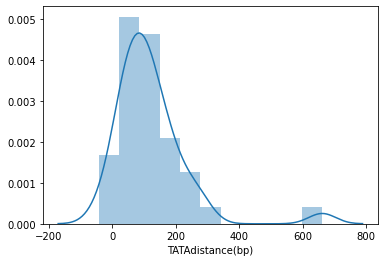

In [57]:
dist_plot = TATA_distance['TATAdistance(bp)']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()
dist_plot_fig.savefig('../../data/plots/TATAbox/TATA_distance_from_extracted_promoters.pdf', format='pdf')


In [58]:
TATA_distance['TATAdistance(bp)']

0     290.0
1      49.0
2      52.0
3      18.0
4      -2.0
5     661.0
6     191.0
7     -43.0
8      84.0
9      40.0
10    130.0
11    217.0
12    260.0
13     73.0
14    114.0
15    177.0
16    101.0
17    182.0
18     91.0
19     84.0
20     53.0
21     36.0
22     30.0
23     77.0
24    103.0
25    147.0
26     50.0
27    125.0
28    106.0
29     95.0
30    124.0
31      1.0
32    172.0
33    161.0
34     44.0
35    248.0
36    126.0
Name: TATAdistance(bp), dtype: float64

In [59]:
#Make TATA box segment the actual size - I will set all to 15 bp
TATA_15bp = TATA.copy()
TATA_15bp

,chrTATA,startTATA,stopTATA,gene_IDTATA,number,strandTATA,TATA_present,promoter_AGI
0,chr1,33116,33117,AT1G01050_1,1,-,yes,AT1G01050
1,chr1,345805,345806,AT1G02000_1,1,+,yes,AT1G02000
2,chr1,1001164,1001165,AT1G03920_1,1,+,yes,AT1G03920
3,chr1,2067339,2067340,AT1G06720_1,1,-,yes,AT1G06720
4,chr1,2190656,2190657,AT1G07135_1,1,-,yes,AT1G07135
...,...,...,...,...,...,...,...,...
86,chr5,23409421,23409422,AT5G57785_1,1,-,yes,AT5G57785
87,chr5,23999727,23999728,AT5G59550_1,1,-,yes,AT5G59550
88,chr5,24326701,24326702,AT5G60490_1,1,-,yes,AT5G60490
89,chr5,25155949,25155950,AT5G62650_1,1,-,yes,AT5G62650


In [60]:
#Make TATA box segment the actual size - I will set all to 15 bp
TATA_15bp.loc[TATA_15bp.strandTATA =='+', 'stopTATA'] = TATA_15bp.stopTATA + 14
TATA_15bp.loc[TATA_15bp.strandTATA =='-', 'startTATA'] = TATA_15bp.startTATA - 14

In [61]:
TATA_15bp

,chrTATA,startTATA,stopTATA,gene_IDTATA,number,strandTATA,TATA_present,promoter_AGI
0,chr1,33102,33117,AT1G01050_1,1,-,yes,AT1G01050
1,chr1,345805,345820,AT1G02000_1,1,+,yes,AT1G02000
2,chr1,1001164,1001179,AT1G03920_1,1,+,yes,AT1G03920
3,chr1,2067325,2067340,AT1G06720_1,1,-,yes,AT1G06720
4,chr1,2190642,2190657,AT1G07135_1,1,-,yes,AT1G07135
...,...,...,...,...,...,...,...,...
86,chr5,23409407,23409422,AT5G57785_1,1,-,yes,AT5G57785
87,chr5,23999713,23999728,AT5G59550_1,1,-,yes,AT5G59550
88,chr5,24326687,24326702,AT5G60490_1,1,-,yes,AT5G60490
89,chr5,25155935,25155950,AT5G62650_1,1,-,yes,AT5G62650


In [62]:
#make into bed file
sorted_TATA = TATA_15bp.sort_values(['chrTATA','startTATA'])
bed = BedTool.from_dataframe(sorted_TATA).saveas('../../data/EPD_promoter_analysis/TATA/TATA_15bp.bed')

In [63]:
#extend promoter 3' end by 661 bp (to furthest registered TATA box)
responsive_constitutive_promoters_extended = sorted_motifs.copy()

In [64]:
responsive_constitutive_promoters_extended.loc[responsive_constitutive_promoters_extended.strand =='+', 'stop'] = responsive_constitutive_promoters_extended.stop + 675
responsive_constitutive_promoters_extended.loc[responsive_constitutive_promoters_extended.strand =='-', 'start'] = responsive_constitutive_promoters_extended.start - 675


In [65]:
sorted_proms = responsive_constitutive_promoters_extended.sort_values(['chr','start'])
bed = BedTool.from_dataframe(sorted_proms).saveas('../../data/EPD_promoter_analysis/TATA/responsive_constitutive_promoters_extended.bed')

In [66]:
#add chr to chromosome name
add_chr_linestart('../../data/EPD_promoter_analysis/TATA/responsive_constitutive_promoters_extended.bed', '../../data/EPD_promoter_analysis/TATA/responsive_constitutive_promoters_extended_renamed.bed')

In [67]:
#rerun analysis using nonbidirectional promoters
nonbidirectional_proms_file = '../../data/FIMO/nonbidirectional_proms.bed'
nonbidirectional_proms = pd.read_table(nonbidirectional_proms_file, sep='\t', header=None)
cols3 = ['chr', 'start', 'stop','promoter_AGI','dot1', 'strand','source_bi', 'type','dot2', 'attributes']
nonbidirectional_proms.columns = cols3

nonbidir_const_var_proms = pd.merge(sorted_motifs, nonbidirectional_proms[['promoter_AGI','source_bi']], how='left', on='promoter_AGI')

In [68]:
nonbidir_const_var_proms = nonbidir_const_var_proms[~nonbidir_const_var_proms['source_bi'].isnull()]
nonbidir_const_var_proms

,chr,start,stop,gene_type,strand,source,attributes,promoter_AGI,source_bi
0,1,281760,282760,highVar,+,Araport11,"Dbxref=PMID:15642518,PMID:15659355,PMID:155317...",AT1G01780,Araport11
3,1,728829,729829,highVar,+,Araport11,"Alias=AtLFG4,LFG4,LIFEGUARD 4;Dbxref=PMID:1708...",AT1G03070,Araport11
4,1,864372,865372,highVar,-,Araport11,"Alias=AtBRN2,BRN2,Bruno-like 2;Dbxref=PMID:149...",AT1G03457,Araport11
5,1,1000115,1001115,highVar,+,Araport11,"Dbxref=PMID:12913170,PMID:13678909,PMID:162916...",AT1G03920,Araport11
6,1,1315138,1316138,highVar,+,Araport11,"Dbxref=PMID:12119167,PMID:14500793,PMID:162916...",AT1G04700,Araport11
...,...,...,...,...,...,...,...,...,...
194,5,22730948,22731948,highVar,+,Araport11,"Dbxref=PMID:18775970,PMID:22914576,locus:21617...",AT5G56160,Araport11
195,5,22956628,22957628,highVar,+,Araport11,"Dbxref=PMID:15574398,PMID:18775970,PMID:199487...",AT5G56750,Araport11
197,5,24669791,24670791,highVar,+,Araport11,"Dbxref=PMID:18775970,locus:2163173;ID=AT5G6136...",AT5G61360,Araport11
198,5,25909014,25910014,housekeeping,+,Araport11,"Dbxref=PMID:17683937,PMID:23144185,locus:50500...",AT5G64813,Araport11


In [69]:
#number of nonbidirectional housekeeping genes
len(nonbidir_const_var_proms[nonbidir_const_var_proms.gene_type == 'housekeeping'])

47

In [70]:
#number of nonbidirectional variable genes
len(nonbidir_const_var_proms[nonbidir_const_var_proms.gene_type == 'highVar'])

73

In [ ]:
gat-run.py --ignore-segment-tracks --segments=../../data/EPD_promoter_analysis/TATA/TATA_15bp.bed `#TATA box annotations` \
    --annotations=../../data/EPD_promoter_analysis/TATA/responsive_constitutive_promoters_extended_renamed.bed `#100 constitutive/responsive promoter annotations` \
    --workspace=../../data/EPD_promoter_analysis/TATA/chromsizes.bed `#Arabidopsis chromosome bed file` \
    --num-samples=1000 --log=../../data/EPD_promoter_analysis/TATA/gat.log > ../../data/EPD_promoter_analysis/TATA/gat_TATA.out

In [85]:
#Create file with only the variable promoters
extended_promoters_file = '../../data/EPD_promoter_analysis/TATA/responsive_constitutive_promoters_extended_renamed.bed'
extended_promoters = pd.read_table(extended_promoters_file, sep='\t', header=None)
#make a new gat workspace file with all promoters (first 3 columns)
bed = BedTool.from_dataframe(extended_promoters[[0,1,2]]).saveas('../../data/EPD_promoter_analysis/TATA/responsive_constitutive_promoters_extended_workspace.bed')
#select only variable promoters
variable_promoters_extended = extended_promoters[extended_promoters[3] == 'highVar']
sorted_variable = variable_promoters_extended.sort_values([0,1])
bed = BedTool.from_dataframe(sorted_variable).saveas('../../data/EPD_promoter_analysis/TATA/variable_promoters_extended.bed')

In [87]:
#make a constitutive only file for completness sake
constitutive_promoters_extended = extended_promoters[extended_promoters[3] == 'housekeeping']
sorted_constitutive = constitutive_promoters_extended.sort_values([0,1])
bed = BedTool.from_dataframe(sorted_constitutive).saveas('../../data/EPD_promoter_analysis/TATA/constitutive_promoters_extended.bed')